In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert/keras/bert_base_en_uncased/3/config.json
/kaggle/input/bert/keras/bert_base_en_uncased/3/tokenizer.json
/kaggle/input/bert/keras/bert_base_en_uncased/3/metadata.json
/kaggle/input/bert/keras/bert_base_en_uncased/3/model.weights.h5
/kaggle/input/bert/keras/bert_base_en_uncased/3/assets/tokenizer/vocabulary.txt
/kaggle/input/question-pairs-dataset/questions.csv


# Importing Data and Libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import string
import nltk
import pickle
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
df = pd.read_csv('/kaggle/input/question-pairs-dataset/questions.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
df.shape

(404351, 6)

In [7]:
df = df.dropna(subset=['question1', 'question2'])
df = df[(df['question1'].str.strip() != '') & (df['question2'].str.strip() != '')]
df = df[(df['question1'].str.len() <= 500) & (df['question2'].str.len() <= 500)]
df = df[~df['question1'].str.contains(r'\d') &  ~df['question2'].str.contains(r'\d')]
df = df[df['question1'].apply(lambda x: isinstance(x, str)) &  df['question2'].apply(lambda x: isinstance(x, str))]
df = df.reset_index(drop=True)

In [8]:
df.shape

(340052, 6)

# Check for Missing Values

In [9]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [10]:
df = df.dropna()

In [11]:
df.shape

(340052, 6)

# Remove Columns

In [12]:
# Remove the 'id', 'qid1', and 'qid2' columns
df = df.drop(['id', 'qid1', 'qid2'], axis=1)
df.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
4,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1


# Checking for Class Balance

In [13]:
duplicate_percentage = df['is_duplicate'].mean() * 100
print(f"Percentage of duplicate pairs: {duplicate_percentage:.2f}%")
print(f"Percentage of non-duplicate pairs: {100 - duplicate_percentage:.2f}%")

Percentage of duplicate pairs: 38.17%
Percentage of non-duplicate pairs: 61.83%


# Text Preprocessing

In [14]:
def preprocess_text(q):

    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()


    return q

In [15]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [16]:
preprocess_text("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [17]:
# Preprocess the questions
df['question1'] = df['question1'].apply(preprocess_text)
df['question2'] = df['question2'].apply(preprocess_text)

# Display the updated DataFrame
df[['question1', 'question2']].head()

,question1,question2
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...
3,which one dissolve in water quikly sugar salt...,which fish would survive in salt water
4,astrology i am a capricorn sun cap moon and c...,i am a triple capricorn sun moon and ascenda...


In [18]:
df.head()

,question1,question2,is_duplicate
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0
4,astrology i am a capricorn sun cap moon and c...,i am a triple capricorn sun moon and ascenda...,1


# Copy of Preprocessed dataset

In [19]:
# Create a new copy of the preprocessed dataset
preprocessed_df = df[['question1', 'question2', 'is_duplicate']].copy()
# Save the preprocessed DataFrame to a CSV file
preprocessed_df.to_csv('preprocessed_questions.csv', index=False)


In [20]:
preprocessed_df.tail()

,question1,question2,is_duplicate
340047,how many keywords are there in the racket prog...,how many keywords are there in perl programmin...,0
340048,do you believe there is life after death,is it true that there is life after death,1
340049,what is one coin,what is this coin,0
340050,what is the approx annual cost of living while...,i am having little hairfall problem but i want...,0
340051,what is like to have sex with cousin,what is it like to have sex with your cousin,0


# Feature Engineering

In [20]:
def compute_token_features(row):
    q1 = row['question1'].split()
    q2 = row['question2'].split()

    # Convert to sets for comparison
    tokens_q1 = set(q1)
    tokens_q2 = set(q2)

    # Count common words
    cwc = len(tokens_q1.intersection(tokens_q2))

    # Count common stop words
    csc = len(tokens_q1.intersection(tokens_q2).intersection(stop_words))

    # Length of questions
    len_q1, len_q2 = len(tokens_q1), len(tokens_q2)

    # Token Features
    cwc_min = cwc / min(len_q1, len_q2) if min(len_q1, len_q2) > 0 else 0
    cwc_max = cwc / max(len_q1, len_q2) if max(len_q1, len_q2) > 0 else 0

    csc_min = csc / min(len([word for word in tokens_q1 if word in stop_words]),
                         len([word for word in tokens_q2 if word in stop_words])) if min(len([word for word in tokens_q1 if word in stop_words]),
                         len([word for word in tokens_q2 if word in stop_words])) > 0 else 0

    csc_max = csc / max(len([word for word in tokens_q1 if word in stop_words]),
                         len([word for word in tokens_q2 if word in stop_words])) if max(len([word for word in tokens_q1 if word in stop_words]),
                         len([word for word in tokens_q2 if word in stop_words])) > 0 else 0

    # Common Tokens
    ctc_min = cwc / min(len_q1, len_q2) if min(len_q1, len_q2) > 0 else 0
    ctc_max = cwc / max(len_q1, len_q2) if max(len_q1, len_q2) > 0 else 0

    # Last and first word equality
    last_word_eq = int(q1[-1] == q2[-1]) if q1 and q2 else 0
    first_word_eq = int(q1[0] == q2[0]) if q1 and q2 else 0

    return pd.Series([cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq])


In [21]:
def compute_length_features(row):
    len_q1 = len(row['question1'].split())
    len_q2 = len(row['question2'].split())

    mean_len = (len_q1 + len_q2) / 2
    abs_len_diff = abs(len_q1 - len_q2)

    # Finding longest common substring ratio
    def longest_common_substring_ratio(s1, s2):
        # Find longest common substring using dynamic programming
        max_length = 0
        for i in range(len(s1)):
            for j in range(len(s2)):
                length = 0
                while (i + length < len(s1)) and (j + length < len(s2)) and (s1[i + length] == s2[j + length]):
                    length += 1
                max_length = max(max_length, length)
        return max_length / min(len(s1), len(s2)) if min(len(s1), len(s2)) > 0 else 0

    longest_substr_ratio = longest_common_substring_ratio(row['question1'], row['question2'])

    return pd.Series([mean_len, abs_len_diff, longest_substr_ratio])

In [22]:
stop_words = set(stopwords.words('english'))

In [23]:
token_features = df[['question1', 'question2']].apply(compute_token_features, axis=1)
token_features.columns = ['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq']
token_features

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
0,1.000000,0.916667,1.000000,1.000000,1.000000,0.916667,0.0,1.0
1,0.700000,0.500000,0.750000,0.600000,0.700000,0.500000,0.0,1.0
2,0.400000,0.285714,0.400000,0.250000,0.400000,0.285714,0.0,1.0
3,0.571429,0.307692,1.000000,0.666667,0.571429,0.307692,0.0,1.0
4,0.750000,0.750000,0.888889,0.800000,0.750000,0.750000,1.0,0.0
...,...,...,...,...,...,...,...,...
340047,0.916667,0.846154,1.000000,0.833333,0.916667,0.846154,1.0,1.0
340048,0.625000,0.625000,0.600000,0.600000,0.625000,0.625000,1.0,0.0
340049,0.750000,0.750000,1.000000,0.666667,0.750000,0.750000,1.0,1.0
340050,0.058824,0.043478,0.125000,0.100000,0.058824,0.043478,0.0,0.0


In [24]:
length_features = df.apply(compute_length_features, axis=1)
length_features.columns = ['mean_len', 'abs_len_diff', 'longest_substr_ratio']
length_features

,mean_len,abs_len_diff,longest_substr_ratio
0,13.0,2.0,1.000000
1,12.5,5.0,0.600000
2,12.0,4.0,0.172414
3,10.0,6.0,0.157895
4,17.0,0.0,0.164706
...,...,...,...
340047,13.5,1.0,0.397436
340048,8.5,1.0,0.650000
340049,4.0,0.0,0.500000
340050,21.0,8.0,0.053763


In [25]:
df = pd.concat([df, token_features, length_features], axis=1)
df.head()

,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,mean_len,abs_len_diff,longest_substr_ratio
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1.000000,0.916667,1.000000,1.000000,1.000000,0.916667,0.0,1.0,13.0,2.0,1.000000
1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.700000,0.500000,0.750000,0.600000,0.700000,0.500000,0.0,1.0,12.5,5.0,0.600000
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.400000,0.285714,0.400000,0.250000,0.400000,0.285714,0.0,1.0,12.0,4.0,0.172414
3,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.571429,0.307692,1.000000,0.666667,0.571429,0.307692,0.0,1.0,10.0,6.0,0.157895
4,astrology i am a capricorn sun cap moon and c...,i am a triple capricorn sun moon and ascenda...,1,0.750000,0.750000,0.888889,0.800000,0.750000,0.750000,1.0,0.0,17.0,0.0,0.164706


# Word 2 Vec Features

In [26]:
# Preprocess text: tokenization and lowercasing
def preprocess(text):
    text = str(text)
    return text.lower().split()

In [27]:
# Tokenize the questions
df['tokens_q1'] = df['question1'].apply(preprocess)
df['tokens_q2'] = df['question2'].apply(preprocess)

In [28]:
# Combine tokens from both questions
all_tokens = df['tokens_q1'].tolist() + df['tokens_q2'].tolist()

In [29]:
# Train Word2Vec model
model_word2vec = Word2Vec(sentences=all_tokens, vector_size=300, window=5, min_count=1, workers=5)

In [30]:
# Save Word2Vec model
model_word2vec.save('word2vec_model.model')

In [31]:
# Function to compute average word vectors for a given list of tokens
def get_vector(tokens):
    vectors = [model_word2vec.wv[word] for word in tokens if word in model_word2vec.wv]
    if not vectors:
        return np.zeros(model_word2vec.vector_size)  # Return zero vector if no words are in the model
    return np.mean(vectors, axis=0)

In [32]:
# Get average vectors for question1 and question2
df['w2v_q1'] = df['tokens_q1'].apply(get_vector)
df['w2v_q2'] = df['tokens_q2'].apply(get_vector)

In [33]:
# Convert list of vectors into a array
w2v_q1_arr = np.array(df['w2v_q1'].tolist())
w2v_q2_arr = np.array(df['w2v_q2'].tolist())

In [34]:
# Create DataFrames from NumPy arrays
w2v_df_q1 = pd.DataFrame(w2v_q1_arr, columns=[f'w2v_q1_{i}' for i in range(w2v_q1_arr.shape[1])])
w2v_df_q2 = pd.DataFrame(w2v_q2_arr, columns=[f'w2v_q2_{i}' for i in range(w2v_q2_arr.shape[1])])

In [35]:
w2v_df_q1

,w2v_q1_0,w2v_q1_1,w2v_q1_2,w2v_q1_3,w2v_q1_4,w2v_q1_5,w2v_q1_6,w2v_q1_7,w2v_q1_8,w2v_q1_9,...,w2v_q1_290,w2v_q1_291,w2v_q1_292,w2v_q1_293,w2v_q1_294,w2v_q1_295,w2v_q1_296,w2v_q1_297,w2v_q1_298,w2v_q1_299
0,0.086333,-0.509497,0.288299,0.480446,0.317292,0.259961,0.054085,-0.073643,-0.246480,0.170372,...,0.023694,0.602618,-0.000473,0.789086,-0.274124,-0.239510,0.551525,-0.113227,-0.025202,-0.252127
1,0.070346,0.029442,0.278365,0.094628,0.074827,-0.340497,0.008130,0.100767,-0.201472,-0.050036,...,-0.131107,0.427074,0.309556,0.345523,-0.056319,0.079601,0.451456,0.021040,0.111923,-0.369116
2,-0.128060,-0.154104,0.474131,0.302121,-0.005159,0.178109,-0.240199,-0.122782,-0.312704,0.210467,...,-0.104270,0.132756,-0.343693,0.212698,-0.670018,-0.494746,0.449046,0.171533,-0.352356,0.283741
3,0.096396,0.362836,-0.244241,0.152432,-0.118755,-0.420882,0.374748,0.590591,-0.079454,-0.409998,...,-0.037097,0.456630,0.135456,0.608500,-0.218080,-0.031982,-0.075195,-0.213762,0.073042,-0.175711
4,-0.163129,-0.106592,0.499181,-0.542454,0.176611,0.017655,0.028123,-0.045695,-0.496739,0.046214,...,-0.105847,0.150095,0.064115,0.597614,-0.306505,0.216416,0.257040,-0.083461,-0.053342,-0.140190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340047,-0.363193,0.212961,0.310087,0.541853,0.145257,0.012692,0.089075,0.469228,-0.206543,0.007619,...,-0.262096,0.588250,-0.215512,0.442513,-0.171788,0.076140,0.451086,-0.326519,-0.268763,0.221019
340048,-0.164226,-0.678104,0.541321,0.009722,0.157146,0.408203,-0.080347,-0.342521,-0.517043,-0.212794,...,-0.078897,0.355083,0.369604,0.780962,0.007260,0.186236,0.514233,0.146660,0.205146,0.000983
340049,0.131238,-0.193753,0.191055,0.213477,0.043632,-0.078243,0.337908,0.002830,-0.410496,-0.224273,...,-0.192770,0.864959,0.687934,0.846772,-0.164791,-0.503013,0.736419,-0.358674,0.418643,-0.482752
340050,0.007471,-0.192614,0.156378,-0.198291,-0.224826,0.097851,0.199035,0.278813,-0.080081,-0.569138,...,-0.341042,0.702994,0.352035,0.113147,-0.412007,-0.354788,0.418009,0.159821,-0.071191,-0.201157


In [36]:
w2v_df_q2

,w2v_q2_0,w2v_q2_1,w2v_q2_2,w2v_q2_3,w2v_q2_4,w2v_q2_5,w2v_q2_6,w2v_q2_7,w2v_q2_8,w2v_q2_9,...,w2v_q2_290,w2v_q2_291,w2v_q2_292,w2v_q2_293,w2v_q2_294,w2v_q2_295,w2v_q2_296,w2v_q2_297,w2v_q2_298,w2v_q2_299
0,0.118041,-0.450275,0.262003,0.571796,0.364179,0.184877,0.157843,-0.185847,-0.350362,0.213236,...,0.007879,0.518821,0.016671,0.820809,-0.260468,-0.175590,0.589772,-0.151572,-0.052050,-0.393796
1,-0.213644,-0.428269,0.314708,0.075329,0.087383,-0.077253,-0.032073,0.160982,-0.287040,-0.220238,...,0.233275,0.627533,0.182333,0.277965,-0.648932,-0.151466,0.493793,-0.106716,-0.063184,-0.160605
2,0.061086,-0.131699,-0.194020,0.668006,0.426417,-0.019431,-0.306909,-0.194940,-0.554551,0.314935,...,0.427254,0.252865,-0.209691,0.448877,-0.265181,-0.612854,0.209273,0.199906,-0.148836,0.020919
3,0.153312,0.280214,0.030881,0.128761,0.100476,-0.268142,0.375228,0.270539,-0.168610,-1.109461,...,0.100772,0.669484,0.443067,1.023147,-0.345084,0.499116,0.252181,-0.386200,0.056503,-0.232724
4,-0.219057,-0.180947,0.607881,-0.535401,0.116818,0.098113,0.019772,-0.109969,-0.390710,0.080786,...,-0.093471,0.091529,0.183185,0.527695,-0.329077,0.136734,0.360869,-0.070693,-0.106388,-0.063339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340047,-0.280753,0.144120,0.298329,0.394886,0.119912,0.111908,0.013706,0.447823,-0.202947,0.079330,...,-0.178948,0.475266,-0.150832,0.496299,-0.099701,0.123012,0.353480,-0.344954,-0.269507,0.387456
340048,-0.194192,-0.627447,0.622446,-0.246086,-0.115167,0.019490,-0.122125,0.135186,-0.563781,-0.331184,...,-0.052111,0.452405,0.452006,0.952588,0.402174,0.257188,0.355983,0.041387,0.384244,-0.408416
340049,-0.463959,-0.197542,0.587867,0.124614,0.154924,-0.043528,-0.060781,0.185314,-0.052210,-0.644330,...,-0.395477,0.879545,0.502217,0.539579,0.023331,-0.245201,0.718359,-0.463484,-0.200855,-0.446398
340050,0.320399,-0.259946,0.435102,-0.308048,0.072009,0.305007,-0.096534,-0.420008,-0.296806,0.370258,...,-0.007945,0.328342,-0.276211,0.352184,-0.597899,-0.129711,0.045192,0.449368,-0.267638,0.275752


In [37]:
# Combine the new features back into the original DataFrame
df = pd.concat([df, w2v_df_q1, w2v_df_q2], axis=1)
# Drop intermediate columns and original questions
df.drop(columns=['tokens_q1', 'tokens_q2', 'w2v_q1', 'w2v_q2', 'question1', 'question2'], inplace=True)

In [38]:
df.head()

,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,mean_len,...,w2v_q2_290,w2v_q2_291,w2v_q2_292,w2v_q2_293,w2v_q2_294,w2v_q2_295,w2v_q2_296,w2v_q2_297,w2v_q2_298,w2v_q2_299
0,0,1.000000,0.916667,1.000000,1.000000,1.000000,0.916667,0.0,1.0,13.0,...,0.007879,0.518821,0.016671,0.820809,-0.260468,-0.175590,0.589772,-0.151572,-0.052050,-0.393796
1,0,0.700000,0.500000,0.750000,0.600000,0.700000,0.500000,0.0,1.0,12.5,...,0.233275,0.627533,0.182333,0.277965,-0.648932,-0.151466,0.493793,-0.106716,-0.063184,-0.160605
2,0,0.400000,0.285714,0.400000,0.250000,0.400000,0.285714,0.0,1.0,12.0,...,0.427254,0.252865,-0.209691,0.448877,-0.265181,-0.612854,0.209273,0.199906,-0.148836,0.020919
3,0,0.571429,0.307692,1.000000,0.666667,0.571429,0.307692,0.0,1.0,10.0,...,0.100772,0.669484,0.443067,1.023147,-0.345084,0.499116,0.252181,-0.386200,0.056503,-0.232724
4,1,0.750000,0.750000,0.888889,0.800000,0.750000,0.750000,1.0,0.0,17.0,...,-0.093471,0.091529,0.183185,0.527695,-0.329077,0.136734,0.360869,-0.070693,-0.106388,-0.063339


# Split the data in traing and testing

In [39]:
X = df.drop(columns=['is_duplicate'])
y = df['is_duplicate']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(272041, 611)
(68011, 611)
(272041,)
(68011,)


# Model 1: Recurrent Neural Network (RNN) with LSTM

In [42]:
# Convert to dense array
X_train_dense = X_train.values
X_test_dense = X_test.values

In [43]:
X_train_dense

array([[ 0.66666667,  0.625     ,  1.        , ..., -0.05567782,
         0.0166258 ,  0.08787916],
       [ 0.25      ,  0.22222222,  0.33333333, ..., -0.15351899,
        -0.2123737 ,  0.17153451],
       [ 0.57142857,  0.44444444,  0.5       , ...,  0.39063701,
        -0.11025742,  0.25995424],
       ...,
       [ 0.55555556,  0.41666667,  0.6       , ...,  0.34050092,
        -0.26303965,  0.24396953],
       [ 0.72727273,  0.72727273,  1.        , ..., -0.16530043,
        -0.1959485 ,  0.44525251],
       [ 0.93333333,  0.93333333,  1.        , ...,  0.23208293,
        -0.20269121,  0.03848198]])

In [44]:
X_test_dense

array([[ 0.90909091,  0.76923077,  0.85714286, ...,  0.34667534,
        -0.24574018,  0.74933916],
       [ 0.85714286,  0.75      ,  1.        , ..., -0.26100931,
         0.19942097, -0.52075088],
       [ 0.4       ,  0.36363636,  0.2       , ...,  0.70857239,
        -0.24737859,  0.43224949],
       ...,
       [ 0.41666667,  0.3125    ,  0.44444444, ..., -0.02824035,
        -0.03703506,  0.03411828],
       [ 0.375     ,  0.375     ,  0.66666667, ..., -0.63179755,
        -0.2756443 ,  0.2056284 ],
       [ 0.5       ,  0.36363636,  0.5       , ...,  0.13645202,
        -0.06186172, -0.63971537]])

In [45]:
# Define the RNN model
rnn_model = Sequential()
rnn_model.add(LSTM(128, input_shape=(X_train_dense.shape[1], 1), return_sequences=True))  # First LSTM layer
rnn_model.add(Bidirectional(LSTM(64, return_sequences=False)))  # Second LSTM layer
rnn_model.add(Dense(32, activation='relu'))  # Fully connected layer
rnn_model.add(Dropout(0.5))  # Dropout layer for regularization
rnn_model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 611, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169,537 (662.25 KB)

 Trainable params: 169,537 (662.25 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
batch_size = 32
epochs = 10 

In [48]:
# Training the model
rnn_model.fit(X_train_dense, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=2)

Epoch 1/10
6801/6801 - 599s - 88ms/step - accuracy: 0.6989 - loss: 0.5311 - val_accuracy: 0.7233 - val_loss: 0.4968
Epoch 2/10
6801/6801 - 599s - 88ms/step - accuracy: 0.7421 - loss: 0.4854 - val_accuracy: 0.7487 - val_loss: 0.4702
Epoch 3/10
6801/6801 - 602s - 88ms/step - accuracy: 0.7549 - loss: 0.4688 - val_accuracy: 0.7634 - val_loss: 0.4607
Epoch 4/10
6801/6801 - 603s - 89ms/step - accuracy: 0.7643 - loss: 0.4563 - val_accuracy: 0.7702 - val_loss: 0.4449
Epoch 5/10
6801/6801 - 604s - 89ms/step - accuracy: 0.7712 - loss: 0.4467 - val_accuracy: 0.7717 - val_loss: 0.4432
Epoch 6/10
6801/6801 - 604s - 89ms/step - accuracy: 0.7764 - loss: 0.4391 - val_accuracy: 0.7765 - val_loss: 0.4395
Epoch 7/10
6801/6801 - 604s - 89ms/step - accuracy: 0.7815 - loss: 0.4318 - val_accuracy: 0.7775 - val_loss: 0.4322
Epoch 8/10
6801/6801 - 604s - 89ms/step - accuracy: 0.7863 - loss: 0.4247 - val_accuracy: 0.7832 - val_loss: 0.4269
Epoch 9/10
6801/6801 - 604s - 89ms/step - accuracy: 0.7894 - loss: 0.418

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix


In [63]:

# Making predictions
y_pred_rnn = rnn_model.predict(X_test_dense)
y_pred_rnn_prob = 1 / (1 + np.exp(-y_pred_rnn))  # Sigmoid function (numerically stable)

# Find optimal threshold using Precision-Recall analysis
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_rnn_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)  # Avoid division by zero
best_threshold = thresholds[np.argmax(f1_scores)]  # Threshold maximizing F1-score

# Apply optimized threshold
y_pred_rnn_binary = (y_pred_rnn_prob >= best_threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rnn_binary)
roc_auc = roc_auc_score(y_test, y_pred_rnn_prob)  # AUC-ROC score

print(f"Optimal Threshold: {best_threshold:.4f}")
print(f"RNN (LSTM) Accuracy: {accuracy:.4f}")
print(f"RNN (LSTM) AUC-ROC: {roc_auc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rnn_binary))


2126/2126 ━━━━━━━━━━━━━━━━━━━━ 77s 36ms/step
Optimal Threshold: 0.5930
RNN (LSTM) Accuracy: 0.7715
RNN (LSTM) AUC-ROC: 0.8769
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.72      0.79     42043
           1       0.65      0.86      0.74     25968

    accuracy                           0.77     68011
   macro avg       0.77      0.79      0.77     68011
weighted avg       0.80      0.77      0.77     68011



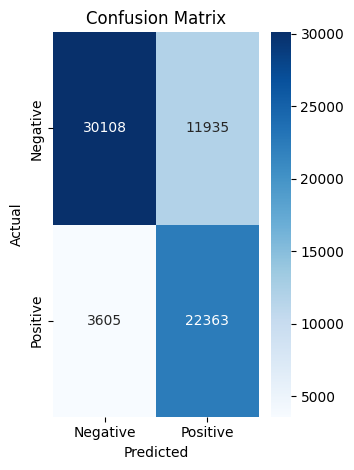

In [62]:
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred_rnn_binary)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

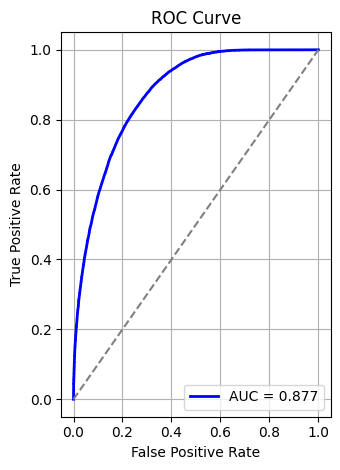

In [57]:
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_rnn_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Model 2: Bert Classification model

In [21]:
!pip install transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [22]:
preprocessed_df.sample(7)

,question1,question2,is_duplicate
117692,does cloudera hire fresh graduate students for...,what type of software engineer has the most de...,0
60884,how should i loose weight,how do i actually lose weight,1
110616,which are the best ways to lose weight,what is the best way to be in a calorie defici...,1
317237,what are some online poetry competitions,are there any genuine online poetry competitio...,1
143148,why are cats so relaxing and calming,why does my cat whine so much,0
38586,how does death feel,what does death feel like,1
55932,what is the secret of happy life,what is the secret to a happy life,0


In [23]:
# 80% Train, 20% Test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    preprocessed_df[['question1', 'question2']],
    preprocessed_df['is_duplicate'],
    test_size=0.2,
    random_state=42
)

# Reset index
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

print("Train size:", len(train_texts))
print("Validation size:", len(val_texts))


Train size: 272041
Validation size: 68011


# Tokenization

In [26]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(q1, q2):
    return tokenizer(
        q1,
        q2,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Create Custom Dataset and Data Loaders

In [27]:
class QuoraDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = tokenize_function(
            self.texts.loc[idx, 'question1'],
            self.texts.loc[idx, 'question2']
        )
        item = {key: val.squeeze(0) for key, val in item.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [28]:
train_dataset = QuoraDataset(train_texts, train_labels)
val_dataset = QuoraDataset(val_texts, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


# Load Bert Model

In [30]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training

In [31]:
from tqdm import tqdm

epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1}, Training loss: {total_loss/len(train_loader)}")


100%|██████████| 17003/17003 [55:53<00:00,  5.07it/s]


Epoch 1, Training loss: 0.31895629995777114


100%|██████████| 17003/17003 [55:29<00:00,  5.11it/s]


Epoch 2, Training loss: 0.2067250199793971


100%|██████████| 17003/17003 [55:16<00:00,  5.13it/s]


Epoch 3, Training loss: 0.1371636799486897


100%|██████████| 17003/17003 [55:15<00:00,  5.13it/s]


Epoch 4, Training loss: 0.09593851104992573


100%|██████████| 17003/17003 [55:14<00:00,  5.13it/s]

Epoch 5, Training loss: 0.07486391322087058


In [32]:
model.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, axis=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())

acc = accuracy_score(true_labels, predictions)
print(f"Validation Accuracy: {acc:.4f}")

100%|██████████| 4251/4251 [04:42<00:00, 15.05it/s]


Validation Accuracy: 0.8969


# Query Pointer

In [33]:
def predict_duplicate(q1, q2):
    model.eval()
    inputs = tokenize_function(q1, q2)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred = torch.argmax(logits, axis=1).item()
    
    return "Duplicate" if pred == 1 else "Not Duplicate"


In [34]:
question1 = "How can I lose weight?"
question2 = "What are the benifits of running?"

print(predict_duplicate(question1, question2))


Not Duplicate


# Creating API End Point Using flask

In [41]:
!pip install -q Flask pyngrok

In [45]:
from pyngrok import ngrok
!ngrok authtoken 2vD7PkNnDdhF5GC2bXjcOrx0uin_54fxPGkc69hJrg9P98umQ
tunnel = ngrok.connect(8501, "http", "us")
public_url = tunnel.public_url
print(public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
https://0844-35-199-186-18.ngrok-free.app


In [ ]:
from flask import Flask, request, jsonify
import torch

# Assume model, tokenizer, device, and tokenize_function are already loaded above (outside this code)

app = Flask(__name__)
@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()

    q1 = data.get('question1')
    q2 = data.get('question2')

    if not q1 or not q2:
        return jsonify({'error': 'Both question1 and question2 are required.'}), 400

    model.eval()
    inputs = tokenize_function(q1, q2)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred = torch.argmax(logits, axis=1).item()

    result = "Duplicate" if pred == 1 else "Not Duplicate"
    return jsonify({'response': result})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=8501)
